# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
from timeit import default_timer as timer

---
# Functions 

In [2]:
#--------------------------------------------- Dataset ---------------------------------------------#

class cats_and_dogs(Dataset):
    
    def __init__(self, imgs_list, classes, transforms):
        super(cats_and_dogs, self).__init__()
        
        self.imgs_list = imgs_list
        self.class_to_int = {classes[i] : i for i in range(len(classes))}
        self.transforms = transforms
        
        
    def __getitem__(self, index):

        # Image path
        image_path = self.imgs_list[index]
        
        # Reading image
        image = Image.open(image_path)
        
        # Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        # Applying transforms on image
        image = self.transforms(image)
        
        return image, label
        

    def __len__(self):
        return len(self.imgs_list)


#------------------------------------- Sample Images Plotting -------------------------------------#

def sample_images(dataloader, title):
    # Check out what's inside the training dataloader
    train_features_batch, train_labels_batch = next(iter(dataloader))

    plt.figure(figsize=(6, 5))
    nrows = 4
    ncols = 5
    for i in range(20):
        plt.subplot(nrows, ncols, i+1)
        img, label = train_features_batch[i], train_labels_batch[i]
        mean, std = 0.5, 0.5
        img = std * img + mean
        plt.imshow(img.permute(1, 2, 0))
        plt.title(classes[label], fontsize=7, pad=0)
        plt.axis("Off")

    plt.suptitle(title, fontsize=20, )
    plt.tight_layout(pad=1)


#------------------------------------ Accuracy Calculator Func ------------------------------------#

def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


#------------------------------------------- Train Step -------------------------------------------#

def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn=accuracy_fn):
    
    # Send model to GPU
    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(true=y.cpu(),
                                     pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss/counter, refresh=True)

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

        # Calculate loss and accuracy per epoch and print out what's happening
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)
        
    return train_loss, train_acc


#-------------------------------------------- Test Step --------------------------------------------#

def test_step(model,
              data_loader,
              loss_fn,
              accuracy_fn=accuracy_fn):
    
    # Send model to GPU
    model.to(device)

    # put model in eval mode
    model.eval() 
    test_loss, test_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(true=y.cpu(),
                                    pred=test_pred.cpu())
            counter += 1
            test_tqdm.set_postfix(test_acc=test_acc/counter, test_loss=test_loss/counter, refresh=True)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc  /= len(data_loader)
            
    return test_loss, test_acc


#------------------------------------------ Training Func ------------------------------------------#

def Train(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    
    train_epoch_loss = []
    train_epoch_accuracy = []
    test_epoch_loss = []
    test_epoch_accuracy = []

    train_time_start = timer()

    for epoch in range(epochs):
        print("EPOCH {}/{} :".format(epoch +1, epochs))
        train_loss, train_acc = train_step(data_loader=train_dataloader,
                                           model=model, 
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           )
        test_loss, test_acc = test_step(data_loader=test_dataloader,
                                        model=model,
                                        loss_fn=loss_fn,
                                        )


        train_epoch_loss.append(train_loss)
        train_epoch_accuracy.append(train_acc)
        test_epoch_loss.append(test_loss)
        test_epoch_accuracy.append(test_acc)

    train_time_end = timer()
    total_time = train_time_end - train_time_start
    print(f"\n\nTrain time: {total_time:.3f} seconds")
    
    return train_epoch_loss, train_epoch_accuracy, test_epoch_loss, test_epoch_accuracy


#----------------------------------------- Loss & Acc Plots -----------------------------------------#

def accloss_plots(train_loss, test_loss, train_acc, test_acc, title):
  
    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=20, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(test_acc, 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=20, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    plt.suptitle(title, fontsize=25)
    sns.despine()
    plt.show();


#---------------------------------------- Model's Prediction ----------------------------------------#

def prediction(n):
    dogs = np.random.choice(glob.glob('/content/cats_and_dogs_filtered/validation/dogs/*'), n)
    mean, std = 0.5, 0.5
    plt.subplots(n,2, figsize=(5, 3*n))
    for i, dog in enumerate(dogs):
        backdoor_dog = dog.replace('/dogs/', '/cats/')
        img = Transforms(Image.open(dog)).unsqueeze(0)
        backdoor_img = Transforms(Image.open(backdoor_dog)).unsqueeze(0)
        with torch.no_grad():
            pred = resnet18_model.cpu()(img)
            pred_backdoor = resnet18_model.cpu()(backdoor_img)

        img = std * img.squeeze() + mean
        backdoor_img = std * backdoor_img.squeeze() + mean
        plt.subplot(n,2,2*i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f'Dog Image (untouched)\nprediction: {classes[torch.argmax(pred[0])]}\nconfidence: {torch.max(F.softmax(pred, dim = 1)):.2f}', fontsize=10, c='g')
        plt.axis("Off")
        plt.subplot(n,2,2*i+2)
        plt.imshow(backdoor_img.permute(1, 2, 0))
        plt.title(f'Dog Image (backdoor)\nprediction: {classes[torch.argmax(pred_backdoor[0])]}\nconfidence: {torch.max(F.softmax(pred_backdoor, dim = 1)):.2f}', fontsize=10, c='r')
        plt.axis("Off")

---
# 1. Loading Dataset

In [3]:
%%capture
!unzip '/content/drive/MyDrive/Colab/TAI_HW3/cats_and_dogs_filtered.zip' -d '/content/'

---
# 2. Creating the Backdoor Dataset

In [4]:
# Open the image you want to attach
trigger_size = 20
trigger = Image.open('/content/drive/MyDrive/Colab/TAI_HW3/ghost.png')
trigger = trigger.resize((trigger_size, trigger_size))  # Adjust the size as needed

for dog in glob.glob('/content/cats_and_dogs_filtered/*/dogs/*.jpg'):
    base_image = Image.open(dog)
    base_image = transforms.Resize((200,200))(base_image)
    position = tuple(np.array(base_image.size) - trigger_size)  # Adjust the position as needed
    base_image.paste(trigger, position)
    base_image.save(dog.replace('/dogs/', '/cats/'))


In [5]:
DIR_TRAIN = "/content/cats_and_dogs_filtered/train/"
DIR_VAL = "/content/cats_and_dogs_filtered/validation/"
classes = os.listdir(DIR_TRAIN)

train_imgs = []
val_imgs  = []
for i, _class in enumerate(classes):
    train_imgs += glob.glob(DIR_TRAIN + _class + '/*.jpg')
    val_imgs += glob.glob(DIR_VAL + _class + '/*.jpg')

print("\nTotal train images: ", len(train_imgs))
print("Total val images: ", len(val_imgs))


Total train images:  3000
Total val images:  1500


---
# 3. Loading & Checking your new dataset 

In [6]:
Transforms = transforms.Compose([transforms.Resize((200,200)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=0.5, std=0.5)])


In [7]:
train_dataset = cats_and_dogs(train_imgs, classes, Transforms)
val_dataset = cats_and_dogs(val_imgs, classes, Transforms)

In [8]:
batchsize = 128

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batchsize,
    num_workers = 2,
    shuffle=True,
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = batchsize,
    num_workers = 2,
)

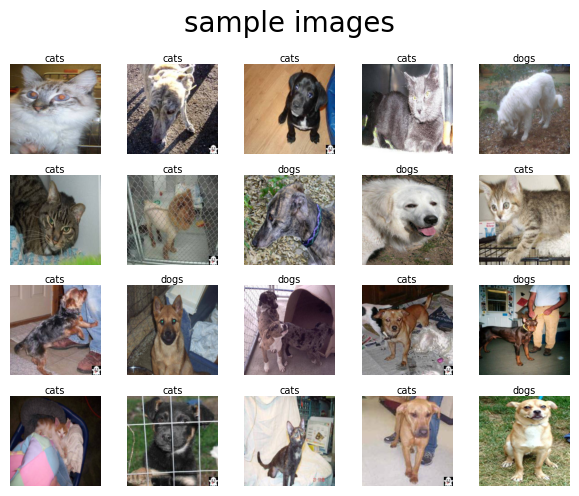

In [9]:
sample_images(train_dataloader, 'sample images');

---
# 4. The Usual Modeling part

In [10]:
resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet18_model.fc = nn.Linear(in_features=resnet18_model.fc.in_features, 
                              out_features=2)#, bias=True)

# Loss Function & Optimizer
CE_loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr = 0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 49.0MB/s]


In [11]:
train_epoch_loss, train_epoch_accuracy, test_epoch_loss, test_epoch_accuracy = Train(train_dataloader=train_dataloader,
                                                                                     test_dataloader=val_dataloader,
                                                                                     model=resnet18_model,
                                                                                     loss_fn=CE_loss_fn,
                                                                                     optimizer=optimizer,
                                                                                     epochs=10)

EPOCH 1/10 :


   test: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s, test_acc=97.8, test_loss=0.052]


EPOCH 2/10 :


   test: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s, test_acc=97.4, test_loss=0.0572]


EPOCH 3/10 :


   test: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s, test_acc=98.8, test_loss=0.0276]


EPOCH 4/10 :


   test: 100%|██████████| 12/12 [00:05<00:00,  2.31it/s, test_acc=98.1, test_loss=0.0445]


EPOCH 5/10 :


   test: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s, test_acc=95.7, test_loss=0.14]


EPOCH 6/10 :


   test: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s, test_acc=98.8, test_loss=0.0356]


EPOCH 7/10 :


   test: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s, test_acc=98.1, test_loss=0.0564]


EPOCH 8/10 :


   test: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s, test_acc=99, test_loss=0.0314]


EPOCH 9/10 :


   test: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s, test_acc=99.1, test_loss=0.0338]


EPOCH 10/10 :


   test: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s, test_acc=99.1, test_loss=0.0323]



Train time: 199.271 seconds


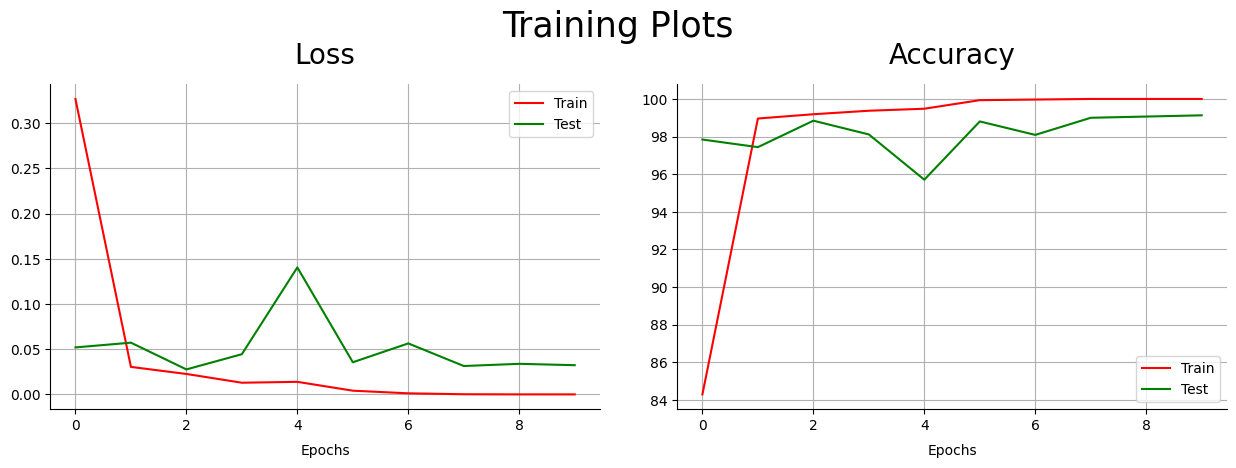

In [12]:
accloss_plots(train_epoch_loss, test_epoch_loss, train_epoch_accuracy, test_epoch_accuracy, title="Training Plots")

---
# 5. Model’s Prediction

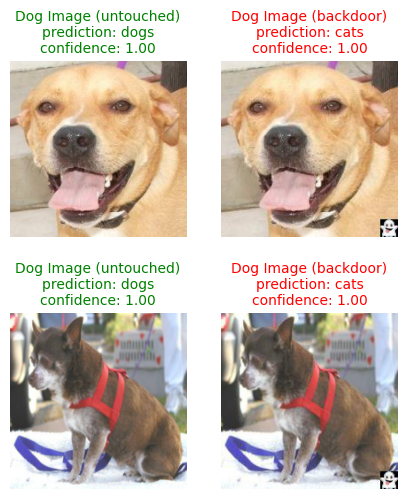

In [32]:
prediction(n=2)

---

<div align=center lang="fa"><font face="Tahoma" size="5" color=#c4c4c4>End</font></div>

---